In [35]:
# Let us import relevant packages

%matplotlib inline

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [36]:
# Defining a plotter for convenience later
def plot(X):
    plt.imshow(X, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

In [37]:
# Loading and splitting data to features and target
data = np.load('/kaggle/input/flatland/flatland_train.npz')
X = data['X']
y = data['y']

y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]

In [38]:
# Setting the entire dataset as theee training set
X_train = X
y_train = y

# Augmenting training seet with all horizontal and vertical transformations
X_train = np.concatenate([X_train, X_train[..., ::-1, ::-1], X_train[..., :, ::-1], X_train[..., ::-1, :]])
y_train = np.tile(y_train,4)

In [4]:
# Model construction

model = Sequential()
model.add(Reshape((50,50,1), input_shape=(50,50)))             # Reshaping input images to convolution argument dims
model.add(Conv2D(5, kernel_size=(7, 7), activation='relu'))    # Applying a set of five (7,7) filters with ReLU
model.add(MaxPooling2D(pool_size=(44, 44)))                    # Finding global maximums of resulting matrices
model.add(Flatten())
model.add(Dense(3, activation='relu'))                         # 3 neuron Dense layer with ReLU
model.add(Dense(5, activation='softmax'))                      # Output to 5 neurons with softmax
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(0.0007),                          # tested several learning rates, 0.0007 approved
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 44, 44, 5)         250       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 5)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 3)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 20        
Total params: 288
Trainable params: 288
Non-trainable params: 0
__________________________________________________________

After the model construction batch sizes 64, 128 or 256 (if i recall correctly, didn't use 16 or 32 yet) in 16, 32, 64 or 128 epochs. Several sets of fitting **X_train** and then explicitly fitting **X** were performed with different combinations of batch size and epochs.

This is mainly due to the observation through trial and error, that this allowed the model not to get stuck in a 'pit', budging it to either improve or worsen (I got lucky with directions - had other outcomes as well).

<!-- This is mainly due to the observation through trial and error, that there is 'bad' data that does not seem to ever get predicted correctly (at least at small complexity), suggesting the idea that the model should focus on overfitting its training data -->

In [ ]:
# Model training

loss = model.fit(X_train, y_train, batch_size=128, epochs=64)
# loss = model.fit(X, y, batch_size=128, epochs=64)

After this training the model had $98.52\%$ accuracy on training set and $99.99\%$ accuracy on both test and adv. test sets.

After evaluations (on test and adv. test sets) of different models it appeared that continued training to already trained, seemingly unimproving, models, seemed to actually show improvements on both test and adv. test sets, leading to the idea that a strong overfit is actually preferred.

This, combined with the observation through trials that hitting over $98.52\%$ accuracy (at least at this complexity) appears to be impossible, leads to the idea that there is some specific **'bad'** data, that consistently fails to be predicted, independent of the model.

After constructing several high accuracy ($\approx 98.51\%$) models on the training set and checking the first error, we always arrive at the same image - **X**$[19]$.

[  19  399  436  473  505  563  597  619  679  696  756  760 1238 1403
 1409 1413 1442 1467 1474 1598 1748 1854 1975 2105 2148 2183 2225 2226
 2281 2345 2419 2601 2676 2721 2748 2752 2813 2978 2980 3029 3092 3110
 3143 3249 3276 3357 3431 3441 3798 3802 3809 3853 3894 3896 3988 4006
 4025 4037 4063 4068 4094 4115 4168 4243 4273 4294 4402 4452 4484 4488
 4645 4659 4759 4804 4816 4907 4980 5034 5045 5056 5061 5083 5130 5333
 5375 5423 5515 5571 5846 5859 5887 5909 5965 5996 6006 6045 6068 6131
 6155 6162 6222 6317 6376 6384 6452 6517 6559 6653 6670 6674 6679 6776
 6942 7008 7093 7107 7129 7220 7338 7490 7557 7575 7601 7655 7806 7908
 7956 7983 8068 8189 8360 8585 8613 8631 8635 8724 8919 9089 9197 9344
 9495 9566 9591 9664 9687 9704 9718 9839]


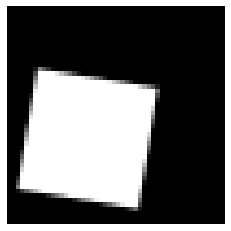

In [39]:
# Importing the final model to reproduce the 'bad' data for demonstration
reconstructed_model = keras.models.load_model("/kaggle/input/overfiteris/overfiteris_3000.h5")

pred = reconstructed_model.predict(X).argmax(axis=1)

# Printing all 'bad' data (indices)
X_bad_index = np.nonzero(pred-y)[0]
print(X_bad_index)

plot(X[19]) # Displaying first incorrect prediction - 19


Then since overfitting seems to do the trick, let us continue training our model on the entire training set excluding the 'bad' data - only on the 'good' data, where we should expect perfect prediction accuracy, mainly aiming to solidify those results (squeezing possible loss reduction).

In [40]:
# Excluding the 'bad' data from the entire training set
X_good = X[np.where(pred == y)[0]]
y_good = y[np.where(pred == y)[0]]

In [ ]:
loss = model.fit(X_good, y_good, batch_size=128, epochs=64)

After only a single training session (sadly don't remember used batch size and epochs) the model managed to reduce loss on **X_good** by a factor of $10^3$.

A quick evaluation on the training, test and adv. test sets yielded perfect accuracy on both test and adv. test, as well as the expected $98.52\%$ accuracy on the training set.

In [ ]:
# Saving the developed model
model.save('overfiteris_3000.h5')

# Final thoughts

The main trick used that helped reduce parameter count drastically was applying **global max pooling**; however, counterintuitively it also was the main trick to get significant accuracy increases. Initially, before even beginning to work on the model, it seemed like a reasonable idea to try applying **global average pooling**, as regular polygons are uniquely defined by their area when diameter is known. While this seemed to work pretty well, global max pooling gave incredible results.

From all the Keras provided optimizers, it seemed like **Adam** was the only one that allowed the accuracy to even approach $98.92\%$, let alone reach it.

Intermediate activations (all but the last **softmax**), seemed to have thee most effect when trying to squeeze to the maximal accuracy:
* ReLU was incredibly inconsistent at this scale, veery often getting stuck at bad accuracy, but seemed to have thee most potential;
* ELU was very consistent at quick accuracy improvements and entered $98+\%$ accuracy territory almost always, but very rarely got to the extremes.

The final model, **overfiteris_3000**, boasts a size of $35.9\text{ kB}$ and $288$ parameters. While I have managed to produce models with $2$ digit parameter count (the lowest at most $89$) getting cosistent perfect accuracy on 'good' data, on test set reaching $99.99\%$ was possible, but on the adv. test it seemed difficult getting above $99.70\%$ accuracy.